# Performance Experiments


## Prerequirements
Docker Demon must be running. 

- Tested on Windows with Python3.11.8 and the requirments.txt installed
- Notebook will take some time like 30 minutes everything is sequential.

## Experiment 1

### Objective
The experiment aims to determine if Protobuf serialization offers performance gains over JSON serialization.

### Setup
The setup involves a series of Python scripts executed in a Jupyter Notebook environment. These scripts automate the creation of Docker containers, Kafka topics, and the generation and sending of messages using Protobuf and JSON serialization formats.

### Procedure
1. **Container and Kafka Topic Preparation**: Initially, all existing Docker containers are removed. Then, Docker containers are set up, and Kafka topics are created for various bus-related data.
2. **Data Generation and Sending**: The core of the experiment involves generating bus data with random attributes and sending these messages to Kafka topics. This process is conducted twice, once using Protobuf serialization and once with JSON, across multiple iterations to gather sufficient data for analysis.

### Results
The script captures metrics such as the number of messages sent, the throughput (messages per second), and the time taken for both Protobuf and JSON serialization methods. Additionally, visualizations are created to compare the throughput of Protobuf versus JSON serialization, providing a clear visual representation of the performance differences.

### Analysis
The experiment includes an analysis phase where the performance data collected from the Protobuf and JSON serialization methods are examined. Key metrics include standard deviation, average throughput, average time, and total messages sent. This data is crucial for understanding the performance characteristics of each serialization method in the context of this experiment.

### Conclusion
While the documentation does not explicitly state the conclusions drawn from the experiment, it implies that the final step involves interpreting the results to determine whether Protobuf provides a significant performance advantage over JSON serialization. This would include considering the throughput, efficiency, and scalability of each method and making informed decisions on which serialization technique is better suited for applications requiring high performance and efficiency in data serialization.

The experiment is thorough and methodical, employing practical tests to directly compare the performance of two widely used serialization techniques. The data collected and the subsequent analysis would be invaluable for making evidence-based decisions on serialization strategies in software development projects, especially those involving large-scale data processing and transmission.


In [1]:
def remove_all_containers():
    import subprocess

    # Get the list of all container IDs
    container_ids = (
        subprocess.check_output(["docker", "ps", "-aq"]).decode().splitlines()
    )

    # Remove all containers
    for container_id in container_ids:
        subprocess.run(["docker", "rm", "-f", container_id])


remove_all_containers()

In [2]:
# docker-compose up
# subprocess.run(["docker-compose", "-f", output_file, "up", "-d"])
import subprocess
import statistics

# subprocess remove all containers
subprocess.run(["docker-compose", "-f", "docker-compose.yml", "up", "-d"])
# wait for 15 seconds
import time

time.sleep(15)

In [3]:
def create_topics(partitions=10, replication_factor=3):
    from confluent_kafka.admin import AdminClient, NewTopic

    a = AdminClient({"bootstrap.servers": "localhost:19093"})

    new_topics = [
        NewTopic(
            topic, num_partitions=partitions, replication_factor=replication_factor
        )
        for topic in [
            "bus_data",
            "restricted_area_alerts",
            "air_quality_data",
            "bus_service_station",
            "bus_locations",
        ]
    ]
    # Note: In a multi-cluster production scenario, it is more typical to use a replication_factor of 3 for durability.

    # Call create_topics to asynchronously create topics. A dict
    # of <topic,future> is returned.
    fs = a.create_topics(new_topics)

    # Wait for each operation to finish.
    for topic, f in fs.items():
        try:
            f.result()  # The result itself is None
            print("Topic {} created".format(topic))
        except Exception as e:
            print("Failed to create topic {}: {}".format(topic, e))


create_topics()

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [4]:
from typing import List

result_json: List[float] = []
result_proto: List[float] = []

In [5]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = "localhost:19092,localhost:19093,localhost:19094"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(10):
        bench = smart_bus.send_bus_data()
        result_proto.append(bench[0])

    print("Standard deviation: ", np.std(result_proto))
    print("Average throughput: ", np.mean(result_proto))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_proto))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_proto) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf.prof")

Sent 10000 messages in 0.56 seconds.
Throughput: 17703.65 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22207.14 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 21039.40 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21778.12 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22248.32 messages per second. 

Sent 10000 messages in 0.47 seconds.
Throughput: 21471.53 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 21999.64 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20999.23 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21641.98 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22638.19 messages per second. 

Standard deviation:  1319.721784060277
Average throughput:  21372.71838518606
Average time:  0.44173145294189453
Average messages:  10000.0
Total messages:  213727.1838518606
Total time:  0.

In [6]:
import math
import random
import time
from confluent_kafka import Producer
import json  # Use the json module for serialization
import cProfile

servers = "localhost:19092,localhost:19093,localhost:19094"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # rint(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data_json", num_messages=10000):
        """Generate and send bus data messages using JSON serialization"""
        start_time = time.time()
        bus_ids = [f"Bus{i}" for i in range(1, 21)]
        bus_types = ["conventional", "electric"]
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):
            bus_id = random.choice(bus_ids)
            bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_capacity = random.randint(30, 60)
            driving_time = random.uniform(0, 24)
            # Construct the message as a dictionary
            message = {
                "bus_id": bus_id,
                "bus_type": bus_type,
                "location": {"lat": lat, "lon": lon},
                "bus_capacity": bus_capacity,
                "people_in_bus": random.randint(0, bus_capacity),
                "driving_time": driving_time,
                "driving_speed": random.uniform(0, 100),
                "engine_temperature": random.uniform(60, 120),
                "timestamp": time.time(),
                "black_box": {
                    "acceleration": random.uniform(0, 10),
                    "braking": random.uniform(0, 10),
                    "fuel_consumption": random.uniform(0, 10),
                    "tire_pressure": random.uniform(1, 3),
                    "error_codes": [
                        random.randint(0, 100) for _ in range(random.randint(0, 5))
                    ],
                },
            }
            if bus_type == "conventional":
                message["fuel_level"] = 100 - (100 / 24 * driving_time)
            else:
                message["battery_level"] = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )

            # Serialize message to JSON
            message_bytes = json.dumps(message).encode("utf-8")
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)

        self.producer.flush()

        end_time = time.time()
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second.\n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(10):
        bench2 = smart_bus.send_bus_data()
        result_json.append(bench2[0])

    print("Standard deviation: ", np.std(result_json))
    print("Average throughput: ", np.mean(result_json))
    print("Average time: ", np.mean(bench2[1]))
    print("Average messages: ", np.mean(bench2[2]))
    print("Total messages: ", np.sum(result_json))
    print("Total time: ", np.sum(bench2[1]))
    print("Total throughput: ", np.sum(result_json) / np.sum(bench2[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_json.prof")

Sent 10000 messages in 1.07 seconds.
Throughput: 9304.97 messages per second.

Sent 10000 messages in 0.59 seconds.
Throughput: 16991.67 messages per second.

Sent 10000 messages in 0.56 seconds.
Throughput: 17935.18 messages per second.

Sent 10000 messages in 0.52 seconds.
Throughput: 19298.25 messages per second.

Sent 10000 messages in 0.53 seconds.
Throughput: 18986.29 messages per second.

Sent 10000 messages in 0.57 seconds.
Throughput: 17463.87 messages per second.

Sent 10000 messages in 0.54 seconds.
Throughput: 18635.50 messages per second.

Sent 10000 messages in 0.54 seconds.
Throughput: 18433.20 messages per second.

Sent 10000 messages in 0.54 seconds.
Throughput: 18582.84 messages per second.

Sent 10000 messages in 0.53 seconds.
Throughput: 18707.02 messages per second.

Standard deviation:  2789.197623139415
Average throughput:  17433.878628794915
Average time:  0.5345587730407715
Average messages:  10000.0
Total messages:  174338.78628794916
Total time:  0.5345587730

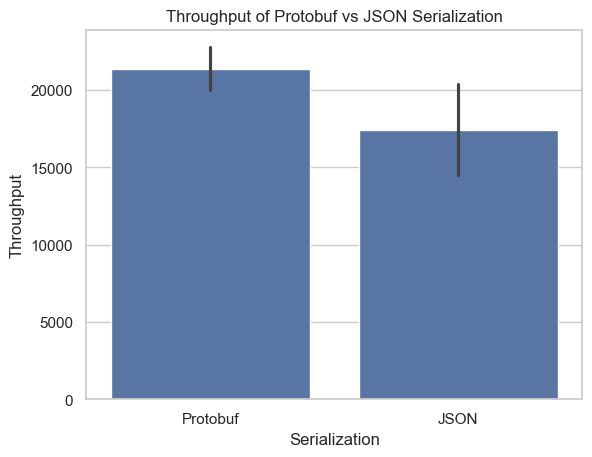

In [7]:
# seaborn visualization of the throughput json against protobuf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


data = pd.DataFrame(
    {
        "Throughput": result_proto + result_json,
        "Serialization": ["Protobuf"] * 10 + ["JSON"] * 10,
    }
)
sns.set(style="whitegrid")
ax = sns.barplot(x="Serialization", y="Throughput", data=data, errorbar="sd")
plt.title("Throughput of Protobuf vs JSON Serialization")
plt.show()

## Experiment 2: 

### Objective
The goal of Experiment 2 is to process real-time bus data streamed through Kafka, calculate service probabilities for each bus based on various factors (e.g., engine temperature, driving speed, time since last service), and decide when a bus should be sent in for service. Here I create a Bottle neck of the Datasink.

### Setup
The setup involves a Python script that uses the `confluent_kafka` package to consume bus data from a Kafka topic, process this data to calculate service probabilities, and then decide whether a bus needs servicing. A Protobuf schema (`smartbus_pb2`) is used for data serialization.

### Procedure
1. **Data Consumption**: The `SmartBusProcessor` class consumes messages from a specified Kafka topic, using Protobuf deserialization for each message.
2. **Service Probability Calculation**: For each message, the service probability is calculated based on the bus's engine temperature, driving speed, and time since it last sent a service signal. This probability calculation considers technical factors and the duration since the bus's last service to dynamically adjust the likelihood of needing service.
3. **Service Decision and Reset**: When a bus's service probability exceeds a certain threshold (e.g., 80%), a signal is sent to potentially reset the bus's service status, and its service probability and seconds without service counter are reset.

### Results
The script measures the time taken to process a fixed number of messages (e.g., 1000 messages) across multiple iterations to gather data on the processing efficiency and responsiveness of the system.

### Analysis
After processing, the experiment analyzes the average execution time and the standard deviation of execution times across all iterations. This analysis provides insights into the performance stability and efficiency of the `SmartBusProcessor` system in real-time data processing scenarios.

### Conclusion
While explicit conclusions are not provided in the documentation, the expected outcome would involve assessing the `SmartBusProcessor`'s ability to effectively and efficiently process real-time bus data, calculate service probabilities accurately, and make timely decisions on when buses should be sent in for service. The experiment seeks to demonstrate the viability of using Kafka and Protobuf for real-time data processing and decision-making in a simulated smart bus service context. 

This experiment underscores the importance of real-time data processing and decision-making in operational contexts, showcasing how modern streaming and serialization technologies can be leveraged to enhance service reliability and operational efficiency.

In [8]:
time_results = []

In [9]:
from confluent_kafka import Consumer, Producer, KafkaError
import smartbus_pb2  # Import the generated Protobuf module
from datetime import datetime
from google.protobuf.timestamp_pb2 import Timestamp
import json
import cProfile


class SmartBusProcessor:
    def __init__(self, servers):
        self.consumer = Consumer(
            {
                "bootstrap.servers": servers,
                "group.id": "bus_processor",
                "auto.offset.reset": "earliest",
            }
        )
        self.service_probabilities = {}
        self.seconds_without_service = {}

    def calculate_service_probability(self, bus_data):
        if bus_data is None:
            return None

        # Probability increases with engine temperature and decreases with driving speed
        engine_temp_factor = bus_data.engine_temperature / 120
        driving_speed_factor = 1 - bus_data.driving_speed / 100
        technical_probability = (engine_temp_factor + driving_speed_factor) / 2

        bus_id = bus_data.bus_id
        # Assuming 100 seconds is the maximum without service
        seconds_factor = self.seconds_without_service.get(bus_id, 0) / 10
        return 0.5 * technical_probability + 0.5 * seconds_factor

    def process_bus_data(self, topic="bus_data"):
        print(f"Subscribing to topic: {topic}")
        self.consumer.subscribe([topic])

        message_count = 0
        last_message_time = datetime.now()

        while message_count < 1000:
            msg = self.consumer.poll(1.0)

            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    print(
                        f"Reached end of topic {msg.topic()} [{msg.partition()}] at offset {msg.offset()}"
                    )
                    continue
                else:
                    print(msg.error())
                    break
            # print("Debug - Consuming message bytes:", msg.value())
            bus_data = smartbus_pb2.BusData()  # Use the BusData message type
            try:
                bus_data.ParseFromString(msg.value())
            except Exception as e:
                print(f"Error parsing message: {e}")
                continue

            bus_id = bus_data.bus_id
            if not bus_id:
                print("Missing bus_id in message")
                continue

            # Calculate the time since the last message in seconds
            current_message_time = datetime.now()
            time_since_last_message = (
                current_message_time - last_message_time
            ).total_seconds()
            last_message_time = current_message_time

            # Update the seconds_without_service for this bus
            self.seconds_without_service[bus_id] = (
                self.seconds_without_service.get(bus_id, 0) + time_since_last_message
            )

            service_probability = self.calculate_service_probability(bus_data)
            timestamp = datetime.now().isoformat()
            if bus_id not in self.service_probabilities:
                self.service_probabilities[bus_id] = []
            self.service_probabilities[bus_id].append(
                {"timestamp": timestamp, "probability": service_probability}
            )

            # If service probability is 80% or more, send bus into service and reset probabilities and seconds without service
            if service_probability is not None and service_probability >= 0.8:
                print(
                    f"Bus {bus_id} has a service probability of {service_probability}. Sending bus into service."
                )
                BusServiceResetter(
                    "localhost:19092,localhost:19093,localhost:19094"
                ).reset_bus_service(bus_id)
                self.service_probabilities[bus_id] = []
                self.seconds_without_service[bus_id] = 0

            message_count += 1
            # Persist to JSON every 100 messages
            if message_count % 100 == 0:
                # This part remains as is since it's for internal tracking, not Kafka messaging
                with open("service_probabilities.json", "w") as f:
                    json.dump(self.service_probabilities, f)

        self.consumer.close()


class BusServiceResetter:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def reset_bus_service(self, bus_id, topic="bus_service_station"):
        print(f"Resetting service for bus {bus_id}")
        # Assuming you have a suitable message type for reset
        reset_message = smartbus_pb2.BusData()
        reset_message.bus_id = bus_id
        timestamp = Timestamp()
        timestamp.FromDatetime(datetime.now())
        reset_message.timestamp


def main():
    execution_times = []
    for _ in range(10):
        smart_bus_processor = SmartBusProcessor(
            "localhost:19092,localhost:19093,localhost:19094"
        )
        start_time = time.time()
        smart_bus_processor.process_bus_data()
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        print(f"Time taken by process_bus_data: {execution_time} seconds")
        time_results.append(execution_time)

    avg_execution_time = sum(execution_times) / len(execution_times)
    std_dev_execution_time = statistics.stdev(execution_times)

    print(f"Average execution time: {avg_execution_time} seconds")
    print(f"Standard deviation of execution time: {std_dev_execution_time} seconds")


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_processor_db100.prof")

Subscribing to topic: bus_data
Time taken by process_bus_data: 2.0419063568115234 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.24890446662902832 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.2626678943634033 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.23402094841003418 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.24554824829101562 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.2285747528076172 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.34301257133483887 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.2537083625793457 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.2527737617492676 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 0.23707103729248047 seconds
Average execution time: 0.43481884002685545 seconds
Standard deviation of execution time: 0.565

In [10]:
time_results_bottleneck = []

In [11]:
import smartbus_pb2  # Import the generated Protobuf module
from datetime import datetime
from google.protobuf.timestamp_pb2 import Timestamp
import json
import cProfile


class SmartBusProcessor:
    def __init__(self, servers):
        self.consumer = Consumer(
            {
                "bootstrap.servers": servers,
                "group.id": "bus_processor",
                "auto.offset.reset": "earliest",
            }
        )
        self.service_probabilities = {}
        self.seconds_without_service = {}

    def calculate_service_probability(self, bus_data):
        if bus_data is None:
            return None

        # Probability increases with engine temperature and decreases with driving speed
        engine_temp_factor = bus_data.engine_temperature / 120
        driving_speed_factor = 1 - bus_data.driving_speed / 100
        technical_probability = (engine_temp_factor + driving_speed_factor) / 2

        bus_id = bus_data.bus_id
        # Assuming 100 seconds is the maximum without service
        seconds_factor = self.seconds_without_service.get(bus_id, 0) / 10
        return 0.5 * technical_probability + 0.5 * seconds_factor

    def process_bus_data(self, topic="bus_data"):
        print(f"Subscribing to topic: {topic}")
        self.consumer.subscribe([topic])

        message_count = 0
        last_message_time = datetime.now()

        while message_count < 1000:
            msg = self.consumer.poll(1.0)

            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    print(
                        f"Reached end of topic {msg.topic()} [{msg.partition()}] at offset {msg.offset()}"
                    )
                    continue
                else:
                    print(msg.error())
                    break

            # print("Debug - Consuming message bytes:", msg.value())
            bus_data = smartbus_pb2.BusData()  # Use the BusData message type
            try:
                bus_data.ParseFromString(msg.value())
            except Exception as e:
                print(f"Error parsing message: {e}")
                continue

            bus_id = bus_data.bus_id
            if not bus_id:
                print("Missing bus_id in message")
                continue

            # Calculate the time since the last message in seconds
            current_message_time = datetime.now()
            time_since_last_message = (
                current_message_time - last_message_time
            ).total_seconds()
            last_message_time = current_message_time

            # Update the seconds_without_service for this bus
            self.seconds_without_service[bus_id] = (
                self.seconds_without_service.get(bus_id, 0) + time_since_last_message
            )

            service_probability = self.calculate_service_probability(bus_data)
            timestamp = datetime.now().isoformat()
            if bus_id not in self.service_probabilities:
                self.service_probabilities[bus_id] = []
            self.service_probabilities[bus_id].append(
                {"timestamp": timestamp, "probability": service_probability}
            )

            # If service probability is 80% or more, send bus into service and reset probabilities and seconds without service
            if service_probability is not None and service_probability >= 0.8:
                print(
                    f"Bus {bus_id} has a service probability of {service_probability}. Sending bus into service."
                )
                BusServiceResetter(
                    "localhost:19092,localhost:19093,localhost:19094"
                ).reset_bus_service(bus_id)
                self.service_probabilities[bus_id] = []
                self.seconds_without_service[bus_id] = 0

            message_count += 1
            # Persist to JSON every 100 messages
            if message_count % 3 == 0:
                # This part remains as is since it's for internal tracking, not Kafka messaging
                with open("service_probabilities.json", "w") as f:
                    json.dump(self.service_probabilities, f)

        self.consumer.close()


class BusServiceResetter:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def reset_bus_service(self, bus_id, topic="bus_service_station"):
        print(f"Resetting service for bus {bus_id}")
        # Assuming you have a suitable message type for reset
        reset_message = smartbus_pb2.BusData()
        reset_message.bus_id = bus_id
        timestamp = Timestamp()
        timestamp.FromDatetime(datetime.now())
        reset_message.timestamp


def main():
    execution_times = []
    for _ in range(10):
        smart_bus_processor = SmartBusProcessor(
            "localhost:19092,localhost:19093,localhost:19094"
        )
        start_time = time.time()
        smart_bus_processor.process_bus_data()
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        print(f"Time taken by process_bus_data: {execution_time} seconds")
        time_results_bottleneck.append(execution_time)

    avg_execution_time = sum(execution_times) / len(execution_times)
    std_dev_execution_time = statistics.stdev(execution_times)

    print(f"Average execution time: {avg_execution_time} seconds")
    print(f"Standard deviation of execution time: {std_dev_execution_time} seconds")


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_processor_db3.prof")

Subscribing to topic: bus_data
Time taken by process_bus_data: 5.65038800239563 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.145787239074707 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.392617702484131 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.172698736190796 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.166945219039917 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.143366813659668 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.130089282989502 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.261882781982422 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.622412204742432 seconds
Subscribing to topic: bus_data
Time taken by process_bus_data: 5.05869460105896 seconds
Average execution time: 5.274488258361816 seconds
Standard deviation of execution time: 0.21070424717825031 seco

[2.0419063568115234, 0.24890446662902832, 0.2626678943634033, 0.23402094841003418, 0.24554824829101562, 0.2285747528076172, 0.34301257133483887, 0.2537083625793457, 0.2527737617492676, 0.23707103729248047]


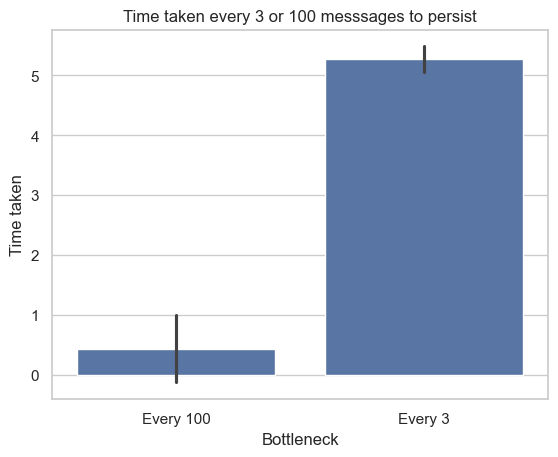

In [12]:
# visualization of the time take vs time taken with bottleneck
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print(time_results)

data = pd.DataFrame(
    {
        "Time taken": time_results + time_results_bottleneck,
        "Bottleneck": ["Every 100"] * 10 + ["Every 3"] * 10,
    }
)
sns.set(style="whitegrid")
ax = sns.barplot(x="Persists every", y="Time taken", data=data, errorbar="sd")
plt.title("Time taken every 3 or 100 messsages to persist")
plt.show()

## Experiment 3: 

### Objective
The experiment aims to estimate the arrival times of buses at a predetermined destination by processing real-time location and speed data from Kafka messages. The objective is to demonstrate the use of real-time data streams in logistical and operational planning within a smart city context.

For this Experiment I compare surrealDB perisistence means real DB with RockDB (Rust) --> High Performance, against CSV which is local that means no network latency and will have significant better time but lets see.

### Setup
The setup involves starting a Python script that produces bus location data to a Kafka topic in the background. Docker containers are used to manage the Kafka brokers and other necessary infrastructure. The main experiment script consumes messages from the Kafka topic, calculates estimated arrival times based on the buses' current locations and speeds, and then either stores these estimates in SurrealDB (a real-time database) or writes them to a CSV file.

### Procedure
1. **Starting Data Producer**: A separate Python script (`SmartStation_Producer.py`) is initiated in the background to simulate the streaming of bus location data to a Kafka topic.
2. **Data Consumption and Processing**: The `BusArrivalEstimator` class consumes bus location data from the Kafka topic, calculates the estimated time of arrival at a specific destination using simple distance and speed calculations, and then either:
   - Saves these estimates to SurrealDB, leveraging asynchronous I/O for efficient data handling.
   - Writes the estimates directly to a CSV file for persistence and further analysis.
3. **Termination and Cleanup**: After processing a predetermined number of messages, the data producer process is terminated, and Docker containers are cleaned up to reset the environment.

### Results
The script measures the time taken to process a fixed number of messages (e.g., 100 messages) and outputs the estimated arrival times for each bus. The performance of the data processing and the efficiency of writing to either a database or a CSV file are key metrics evaluated in this experiment.

### Analysis
The experiment includes performance profiling (using Python's `cProfile` module) to identify any bottlenecks or inefficiencies in the message processing and data handling pipeline. This analysis helps in understanding the scalability of the approach and the potential impact of various factors (e.g., network latency, database write times) on overall performance.

### Conclusion
While explicit conclusions are not provided in the documentation, the expected outcome would involve assessing the viability of using Kafka and Python for real-time data processing in smart city applications, specifically for estimating bus arrival times. The experiment seeks to demonstrate how streaming data can be effectively processed and utilized for operational planning and decision-making, with a focus on the practical implications of technology choices (e.g., database vs. CSV storage) on performance and scalability.

This experiment highlights the potential of integrating streaming data with real-time databases or simple file-based storage solutions to support smart city logistics and transportation management, emphasizing the importance of efficient data processing pipelines in achieving timely and accurate operational insights.

As we can see the CSV is way performant because it has nearly zero latency but CSV is not optimal for scaling horizotal with more than 1 consumer. If there are more Consumers SurrealDB will be the better choice, since SurrealDB has sharding and Vertical and Horizontal Scaling.


In [13]:
# start python script SmartStation_Producer.py in the background
import subprocess

# get process id
pid = subprocess.Popen(["python", "SmartStation_Producer.py"]).pid
print("Process id: ", pid)

Process id:  19128


In [14]:
import nest_asyncio

nest_asyncio.apply()

In [15]:
time_results_surreal = []
time_results_csv = []

In [16]:
import cProfile
from confluent_kafka import Consumer, KafkaError
import json
import asyncio
from surrealdb import Surreal

# Kafka Consumer Configuration
servers = "localhost:19092,localhost:19093,localhost:19094"
topic = "bus_locations"


class BusArrivalEstimator:
    def __init__(self, server_list):
        self.consumer = Consumer(
            {
                "bootstrap.servers": server_list,
                "group.id": "bus_arrival_estimator",
                "auto.offset.reset": "latest",
            }
        )
        self.consumer.subscribe([topic])

    def estimate_arrival_time(self, lat, lon, speed):
        destination_lat, destination_lon = (
            47.560,
            7.590,
        )  # Fixed destination coordinates
        distance_km = self.calculate_distance(
            lat, lon, destination_lat, destination_lon
        )
        if speed <= 0:
            return float("inf")  # Avoid division by zero
        time_hours = distance_km / speed
        return time_hours * 60  # Convert hours to minutes

    def calculate_distance(self, lat1, lon1, lat2, lon2):
        # Approximation
        return ((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) ** 0.5 * 111.32

    async def process_messages(self, db):
        counter = 0
        while counter < 100:
            msg = self.consumer.poll(1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    continue
                else:
                    print(msg.error())
                    break

            message = json.loads(msg.value().decode("utf-8"))
            print(message)
            arrival_time = self.estimate_arrival_time(
                message["location"]["lat"], message["location"]["lon"], message["speed"]
            )
            print(
                f"Bus {message['bus_id']} will arrive in approximately {arrival_time:.2f} minutes."
            )

            counter += 1

            # measure the time taken to save to the database
            start_time = time.perf_counter()
            # Save to SurrealDB
            await db.query(f"""
            insert into bus_arrivals {{
                bus_id: '{message['bus_id']}',
                location: {{lat: {message["location"]["lat"]}, lon: {message["location"]["lon"]}}},
                arrival_time: {arrival_time},
                destination: {{lat: 47.560, lon: 7.590}}
            }};
            """)
            end_time = time.perf_counter()
            time_results_surreal.append(end_time - start_time)


async def main():
    async with Surreal("ws://localhost:8000/rpc") as db:
        await db.signin({"user": "etiiir", "pass": "Welcome12"})
        await db.use("Bus", "SmartCity")
        print("Connected to SurrealDB")
        estimator = BusArrivalEstimator(servers)
        await estimator.process_messages(db)
        print("Done processing messages")
        estimator.consumer.close()


def run_main():
    # since i cannot use cprofile with asyncio.run i will use %prune cummulative
    asyncio.run(main())


%prun -s cumulative run_main()  

Connected to SurrealDB
{'bus_id': 'Bus128', 'timestamp': 1712411946.292511, 'location': {'lat': 47.54915622338999, 'lon': 7.576648387171126}, 'speed': 47.70996962481462}
Bus Bus128 will arrive in approximately 2.41 minutes.
{'bus_id': 'Bus144', 'timestamp': 1712411946.5071013, 'location': {'lat': 47.56895303294231, 'lon': 7.571164479216859}, 'speed': 42.00597524869423}
Bus Bus144 will arrive in approximately 3.32 minutes.
{'bus_id': 'Bus155', 'timestamp': 1712411946.7207968, 'location': {'lat': 47.55635646962399, 'lon': 7.582811789046755}, 'speed': 39.93365116613032}
Bus Bus155 will arrive in approximately 1.35 minutes.
{'bus_id': 'Bus74', 'timestamp': 1712411946.3960311, 'location': {'lat': 47.56515288617941, 'lon': 7.579129462718568}, 'speed': 42.15061603693235}
Bus Bus74 will arrive in approximately 1.91 minutes.
{'bus_id': 'Bus54', 'timestamp': 1712411946.6106656, 'location': {'lat': 47.559288299541535, 'lon': 7.58407497908248}, 'speed': 42.819567102786586}
Bus Bus54 will arrive in

         54237 function calls (53895 primitive calls) in 10.642 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     37/1    0.001    0.000   10.643   10.643 {built-in method builtins.exec}
        1    0.000    0.000   10.643   10.643 3940219872.py:90(run_main)
        1    0.000    0.000   10.643   10.643 nest_asyncio.py:25(run)
        1    0.001    0.001   10.642   10.642 nest_asyncio.py:86(run_until_complete)
      433    0.004    0.000   10.642    0.025 nest_asyncio.py:100(_run_once)
      449    0.001    0.000   10.372    0.023 events.py:82(_run)
      449    0.001    0.000   10.371    0.023 {method 'run' of '_contextvars.Context' objects}
      223    0.002    0.000   10.363    0.046 tasks.py:260(__step)
      221    0.000    0.000   10.361    0.047 {method 'send' of 'coroutine' objects}
      106    0.000    0.000   10.350    0.098 3940219872.py:79(main)
      217    0.000    0.000   10.314    0.048 tasks.py:347(

In [17]:
# stop pid
import os
import signal

# Kill the process
os.kill(int(pid), signal.SIGTERM)

In [18]:
remove_all_containers()

In [19]:
# subprocess remove all containers
subprocess.run(["docker-compose", "-f", "docker-compose.yml", "up", "-d"])
# wait for 15 seconds
time.sleep(10)
create_topics()
time.sleep(2)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [20]:
# start python script SmartStation_Producer.py in the background
import subprocess

# get process id
pid = subprocess.Popen(["python", "SmartStation_Producer.py"]).pid
print("Process id: ", pid)

Process id:  121216


In [21]:
import cProfile
import time
from confluent_kafka import Consumer, KafkaError
import json
import csv  # Import the csv module

# Kafka Consumer Configuration
servers = "localhost:19092,localhost:19093,localhost:19094"
topic = "bus_locations"


class BusArrivalEstimator:
    def __init__(self, server_list):
        self.consumer = Consumer(
            {
                "bootstrap.servers": server_list,
                "group.id": "bus_arrival_estimator",
                "auto.offset.reset": "latest",
                "enable.auto.commit": False,
            }
        )
        self.consumer.subscribe([topic])

    def estimate_arrival_time(self, lat, lon, speed):
        destination_lat, destination_lon = (
            47.560,
            7.590,
        )  # Fixed destination coordinates
        distance_km = self.calculate_distance(
            lat, lon, destination_lat, destination_lon
        )
        if speed <= 0:
            return float("inf")  # Avoid division by zero
        time_hours = distance_km / speed
        return time_hours * 60  # Convert hours to minutes

    def calculate_distance(self, lat1, lon1, lat2, lon2):
        # Approximation
        return ((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) ** 0.5 * 111.32

    def process_messages(self):
        counter = 0
        # Open the CSV file here, with write ('w') mode and newline='' for compatibility
        with open("bus_arrivals.csv", mode="w", newline="") as file:
            writer = csv.writer(file)
            # Write the CSV header
            writer.writerow(
                [
                    "bus_id",
                    "latitude",
                    "longitude",
                    "arrival_time",
                    "destination_lat",
                    "destination_lon",
                ]
            )
            while counter < 100:
                msg = self.consumer.poll(1.0)
                if msg is None:
                    print("None")
                    continue
                if msg.error():
                    if msg.error().code() == KafkaError._PARTITION_EOF:
                        continue
                    else:
                        print(msg.error())
                        break

                message = json.loads(msg.value().decode("utf-8"))
                print(message)
                arrival_time = self.estimate_arrival_time(
                    message["location"]["lat"],
                    message["location"]["lon"],
                    message["speed"],
                )
                print(
                    f"Bus {message['bus_id']} will arrive in approximately {arrival_time:.2f} minutes."
                )
                start_time = time.perf_counter()
                # Write to the CSV instead of saving to the database
                writer.writerow(
                    [
                        message["bus_id"],
                        message["location"]["lat"],
                        message["location"]["lon"],
                        arrival_time,
                        47.560,
                        7.590,
                    ]
                )
                end_time = time.perf_counter()
                time_results_csv.append(end_time - start_time)
                counter += 1


def main():
    estimator = BusArrivalEstimator(servers)
    estimator.process_messages()
    print("Done processing messages")
    print("Time results:", time_results_csv)


# Profile the main function to analyze performance
%prun -s cumulative main()

None
None
{'bus_id': 'Bus69', 'timestamp': 1712411976.389621, 'location': {'lat': 47.54884251454173, 'lon': 7.587331481411311}, 'speed': 35.17686119150031}
Bus Bus69 will arrive in approximately 2.18 minutes.
{'bus_id': 'Bus24', 'timestamp': 1712411976.2820494, 'location': {'lat': 47.552868591599605, 'lon': 7.577912930513712}, 'speed': 52.145475566883064}
Bus Bus24 will arrive in approximately 1.80 minutes.
{'bus_id': 'Bus16', 'timestamp': 1712411976.5127063, 'location': {'lat': 47.54543634897715, 'lon': 7.597880218200008}, 'speed': 47.19603101039413}
Bus Bus16 will arrive in approximately 2.34 minutes.
{'bus_id': 'Bus76', 'timestamp': 1712411976.6207914, 'location': {'lat': 47.555806642106106, 'lon': 7.580159649690295}, 'speed': 32.161161022420046}
Bus Bus76 will arrive in approximately 2.22 minutes.
{'bus_id': 'Bus45', 'timestamp': 1712411976.7295187, 'location': {'lat': 47.56575630700716, 'lon': 7.591662679215247}, 'speed': 38.213345987511936}
Bus Bus45 will arrive in approximately 

         7292 function calls in 12.546 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.546   12.546 {built-in method builtins.exec}
        1    0.002    0.002   12.546   12.546 <string>:1(<module>)
        1    0.000    0.000   12.544   12.544 502580659.py:96(main)
        1    0.003    0.003   12.543   12.543 502580659.py:41(process_messages)
      102   12.521    0.123   12.521    0.123 {method 'poll' of 'cimpl.Consumer' objects}
      204    0.002    0.000    0.012    0.000 {built-in method builtins.print}
      410    0.003    0.000    0.010    0.000 iostream.py:655(write)
      410    0.000    0.000    0.005    0.000 iostream.py:577(_schedule_flush)
       45    0.000    0.000    0.005    0.000 iostream.py:259(schedule)
       45    0.004    0.000    0.004    0.000 socket.py:621(send)
      100    0.001    0.000    0.004    0.000 __init__.py:299(loads)
      100    0.001    0.000    

In [22]:
# stop pid
import os
import signal

# Kill the process
os.kill(int(pid), signal.SIGTERM)

100
100


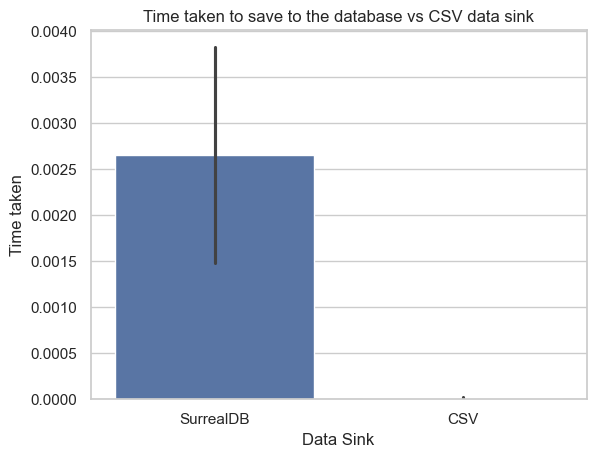

In [23]:
# visualization of the time taken to save to the database vs csv data sink
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print(time_results_surreal.__len__())
print(time_results_csv.__len__())

# plot the time taken to save to the database vs csv data sink
data = pd.DataFrame(
    {
        "Time taken": time_results_surreal + time_results_csv,
        "Data Sink": ["SurrealDB"] * 100 + ["CSV"] * 100,
    }
)
sns.set(style="whitegrid")
ax = sns.barplot(x="Data Sink", y="Time taken", data=data, errorbar="sd")
plt.title("Time taken to save to the database vs CSV data sink")
plt.show()

## Experiment 4: 

Experiment 4 focuses on comparing the performance implications of different Kafka partition configurations for handling bus data. Specifically, it examines how the number of partitions—1 vs. 100—affects the throughput and efficiency of processing messages for 100 simulated buses. This experiment aims to identify the optimal partition setup for balancing load and minimizing latency in a real-time data processing scenario.

### Objective
To evaluate the impact of Kafka partition configurations on the performance of processing bus data. The experiment compares two scenarios: using 10 partitions and using 100 partitions for 100 bus data producers.

### Setup
- A Docker environment is prepared with Kafka brokers and a custom Docker image (`smart_bus_image`) for simulating bus data production.
- A `docker-compose` YAML file is dynamically generated to include services for each bus, Kafka brokers, and a Kafdrop UI for monitoring Kafka topics.
- The Kafka environment is configured with three brokers and a replication factor of 3 for durability and high availability.
- One has 1 Partition and one 100 partition of the runs.

### Procedure
1. **Docker Environment Preparation**: The environment is set up with the necessary Kafka brokers and a monitoring tool (Kafdrop). A custom Docker image for simulating bus data is built and used in the composition.
2. **Dynamic Docker Compose Generation**: A Python script generates a `docker-compose` file that includes configurations for 100 bus services, each simulated by a Docker container using the `smart_bus_image`.
3. **Kafka Topic Creation**: Topics are created with different partition counts (10 and 100) to compare the effects of partition configurations on data processing performance.
4. **Data Production and Consumption**: The bus data producers generate messages that simulate bus statuses, which are then consumed by a `SmartBusProcessor`. This processor calculates various metrics, such as service probabilities based on the data.
5. **Performance Measurement**: The throughput and latency of message processing are measured and recorded for analysis. The system's behavior under both partition configurations is closely monitored.

### Results
- The experiment captures metrics such as average throughput (messages per second) and the standard deviation of throughput for both partition scenarios.
- Observations regarding the system's stability, message lag, and consumer performance under each configuration are noted.

### Analysis
- The data collected is analyzed to determine the impact of partition count on performance. Key factors considered include message processing rate, latency, and the distribution of messages across partitions.
- The experiment identifies bottlenecks and efficiency differences between the two partitioning strategies, providing insights into how partition count affects Kafka's performance for real-time data processing tasks.

### Conclusion
Based on the results, conclusions are drawn regarding the optimal Kafka partition configuration for handling real-time bus data. The experiment aims to guide decisions on partitioning strategies to achieve balanced load distribution, minimal processing latency, and high throughput in a production environment. Recommendations for further optimization and potential areas for improvement in the system's architecture and configuration may also be provided, based on the findings.

In [24]:
#
# docker build image
# install yaml
import os
import subprocess

# docker buuild image smart_bus_image
current_dir = os.getcwd()
subprocess.run(["docker", "build", "--pull", "--rm", "-t", "smart_bus_image", "."])

CompletedProcess(args=['docker', 'build', '--pull', '--rm', '-t', 'smart_bus_image', '.'], returncode=0)

In [25]:
import yaml
import os

num_buses = 100
services = {
    "kafka1": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka1",
        "hostname": "kafka1",
        "ports": ["19092:19092"],
        "environment": {
            "KAFKA_NODE_ID": 1,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19092",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka1:9092,EXTERNAL://localhost:19092",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafka2": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka2",
        "hostname": "kafka2",
        "ports": ["19093:19093"],
        "environment": {
            "KAFKA_NODE_ID": 2,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19093",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka2:9092,EXTERNAL://localhost:19093",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafka3": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka3",
        "hostname": "kafka3",
        "ports": ["19094:19094"],
        "environment": {
            "KAFKA_NODE_ID": 3,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19094",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka3:9092,EXTERNAL://localhost:19094",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafdrop": {
        "image": "obsidiandynamics/kafdrop:latest",
        "container_name": "kafdrop1",
        "ports": ["9000:9000"],
        "environment": {
            "KAFKA_BROKERCONNECT": "kafka1:9092,kafka2:9092,kafka3:9092",
            "SERVER_SERVLET_CONTEXTPATH": "/",
        },
        "depends_on": ["kafka1", "kafka2", "kafka3"],
    },
}

for i in range(1, num_buses + 1):
    bus_id = f"bus{i}"
    services[bus_id] = {
        "image": "smart_bus_image",
        "environment": {"BUS_ID": bus_id},
        "depends_on": ["kafka1", "kafka2", "kafka3"],
    }

compose_file = {"version": "3.8", "services": services}

current_dir = os.getcwd()

output_file = os.path.join(current_dir, "docker-compose.generated.yml")
with open(output_file, "w") as f:
    yaml.dump(compose_file, f, sort_keys=False)

In [26]:
# docker-compose up
# docker remove all containers
remove_all_containers()
subprocess.run(["docker-compose", "-f", output_file, "up", "-d"])
create_topics(partitions=100, replication_factor=3)
time.sleep(100)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [27]:
from confluent_kafka import Consumer, Producer, KafkaError
import smartbus_pb2  # Import the generated Protobuf module
from datetime import datetime
from google.protobuf.timestamp_pb2 import Timestamp
import json
import time
import cProfile
import statistics

throughput_list_100 = []


class SmartBusProcessor:
    def __init__(self, servers):
        self.consumer = Consumer(
            {
                "bootstrap.servers": servers,
                "group.id": "bus_processor",
                "auto.offset.reset": "latest",
            }
        )
        self.service_probabilities = {}
        self.seconds_without_service = {}

    def calculate_service_probability(self, bus_data):
        if bus_data is None:
            return None

        # Probability increases with engine temperature and decreases with driving speed
        engine_temp_factor = bus_data.engine_temperature / 120
        driving_speed_factor = 1 - bus_data.driving_speed / 100
        technical_probability = (engine_temp_factor + driving_speed_factor) / 2

        bus_id = bus_data.bus_id
        seconds_factor = (
            self.seconds_without_service.get(bus_id, 0) / 10
        )  # Assuming 100 seconds is the maximum without service
        return 0.5 * technical_probability + 0.5 * seconds_factor

    def process_bus_data(self, topic="bus_data"):
        print(f"Subscribing to topic: {topic}")
        self.consumer.subscribe([topic])

        message_count = 0
        start_time = time.time()

        while message_count < 10000:
            msg = self.consumer.poll(1.0)
            print(msg)
            if msg is None:
                # print("none")
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    print(
                        f"Reached end of topic {msg.topic()} [{msg.partition()}] at offset {msg.offset()}"
                    )
                    continue
                else:
                    print(msg.error())
                    break

            print(msg.value())
            bus_data = smartbus_pb2.BusData()  # Use the BusData message type
            try:
                bus_data.ParseFromString(msg.value())
            except Exception as e:
                print(f"Error parsing message: {e}")
                continue

            bus_id = bus_data.bus_id
            if not bus_id:
                print("Missing bus_id in message")
                continue

            message_count += 1
            elapsed_time = time.time() - start_time
            throughput = message_count / elapsed_time
            throughput_list_100.append(throughput)

        self.consumer.close()
        print(
            f"Average throughput: {sum(throughput_list_100) / len(throughput_list_100)} messages per second"
        )
        print(
            f"Standard deviation of throughput: {self.calculate_std_dev(throughput_list_100)} messages per second"
        )

    @staticmethod
    def calculate_std_dev(data):
        return statistics.stdev(data)


def main():
    smart_bus_processor = SmartBusProcessor(
        "localhost:19092,localhost:19093,localhost:19094"
    )
    smart_bus_processor.process_bus_data()
    smart_bus_processor.consumer.close()


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_processor_100Partitons.prof")

Subscribing to topic: bus_data
None
b"\n\x05Bus17\x12\x0cconventional\x1a\x12\t\xd1Pf\xcb}\xb2G@\x11\x1c\xc5\x19\xc9t\x83\x1e@ '(\x175\x18jSA=\xc1\xcdsAE\xd4x\xa5BI\xa1W\xffvU\x84\xd9AR\x17\r\xd8X\x83@\x15?\xe6\x06A\x1dj+\x06A%X\x80/@*\x01\x01]\xd2\xc63B"
b'\n\x05Bus16\x12\x08electric\x1a\x12\t\xe8\xf6\xad\xa6\xf7\xc0G@\x11\xb3P\x8d\xf7\xae\x8a\x1e@ )5\x85\x17VA=h\xda\x85BE\x13[\x96BI\x8fX\xffvU\x84\xd9AR\x17\ri|\x1aA\x15\xbe\xa0\xd0@\x1d,bl=%\xfe\xf8\xd2?*\x01\x0ee\xc4P\xc5B'
b"\n\x05Bus15\x12\x0cconventional\x1a\x12\t\xf3\xb9\xba\x19`\xd0G@\x11/'\x05nI<\x1f@ &(&5\x83qFA=\x0bH\xa5BE\xed\xbe\x99BI\xe2X\xffvU\x84\xd9AR\x1a\r\xe7\xa0\x1d@\x15\xa0\xcd\x04A\x1d\xa8H\x12@%L\x83\xeb?*\x04XIN[]\xc2IAB"
b'\n\x04Bus6\x12\x08electric\x1a\x12\t\xd2\xb8\x8d\xcc\xe9\xcaG@\x117\xb0\xefk\xec \x1e@ ,(\x1b5<c\xa0A=\xb5\x902BE7\xaf\xc1BI$Y\xffvU\x84\xd9AR\x1b\r\xdc\xcc\x13@\x15\xea\x10\xef@\x1dp\\T@%\x03\xe7\x01@*\x05F\t\x08U\x0ee\xb3\xa6\xc6B'
b'\n\x05Bus12\x12\x0cconventional\x1a\x12\tL\x06-\xd1\x06\x

In [28]:
import yaml
import os
import subprocess

num_buses = 100
services = {
    "kafka1": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka1",
        "hostname": "kafka1",
        "ports": ["19092:19092"],
        "environment": {
            "KAFKA_NODE_ID": 1,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19092",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka1:9092,EXTERNAL://localhost:19092",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafka2": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka2",
        "hostname": "kafka2",
        "ports": ["19093:19093"],
        "environment": {
            "KAFKA_NODE_ID": 2,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19093",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka2:9092,EXTERNAL://localhost:19093",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafka3": {
        "image": "confluentinc/cp-kafka",
        "container_name": "kafka3",
        "hostname": "kafka3",
        "ports": ["19094:19094"],
        "environment": {
            "KAFKA_NODE_ID": 3,
            "KAFKA_CONTROLLER_LISTENER_NAMES": "CONTROLLER",
            "KAFKA_LISTENER_SECURITY_PROTOCOL_MAP": "CONTROLLER:PLAINTEXT,INTERNAL:PLAINTEXT,EXTERNAL:PLAINTEXT",
            "KAFKA_LISTENERS": "INTERNAL://:9092,CONTROLLER://:9093,EXTERNAL://:19094",
            "KAFKA_ADVERTISED_LISTENERS": "INTERNAL://kafka3:9092,EXTERNAL://localhost:19094",
            "KAFKA_INTER_BROKER_LISTENER_NAME": "INTERNAL",
            "KAFKA_CONTROLLER_QUORUM_VOTERS": "1@kafka1:9093,2@kafka2:9093,3@kafka3:9093",
            "KAFKA_PROCESS_ROLES": "broker,controller",
            "KAFKA_GROUP_INITIAL_REBALANCE_DELAY_MS": 0,
            "KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR": 3,
            "KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR": 3,
            "CLUSTER_ID": "BDb4EWyiS1GjcEKCew2HvQ",
            "KAFKA_LOG_DIRS": "/tmp/kraft-combined-logs",
        },
    },
    "kafdrop": {
        "image": "obsidiandynamics/kafdrop:latest",
        "container_name": "kafdrop1",
        "ports": ["9000:9000"],
        "environment": {
            "KAFKA_BROKERCONNECT": "kafka1:9092,kafka2:9092,kafka3:9092",
            "SERVER_SERVLET_CONTEXTPATH": "/",
        },
        "depends_on": ["kafka1", "kafka2", "kafka3"],
    },
}

for i in range(1, num_buses + 1):
    bus_id = f"bus{i}"
    services[bus_id] = {
        "image": "smart_bus_image",
        "environment": {"BUS_ID": bus_id},
        "depends_on": ["kafka1", "kafka2", "kafka3"],
    }

compose_file = {"version": "3.8", "services": services}

current_dir = os.getcwd()

output_file = os.path.join(current_dir, "docker-compose.generated.yml")
with open(output_file, "w") as f:
    yaml.dump(compose_file, f, sort_keys=False)

In [29]:
# docker-compose up
# docker remove all containers
remove_all_containers()
subprocess.run(["docker-compose", "-f", output_file, "up", "-d"])
create_topics(partitions=1, replication_factor=3)
time.sleep(60)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [30]:
from confluent_kafka import Consumer, Producer, KafkaError
import smartbus_pb2  # Import the generated Protobuf module
from datetime import datetime
from google.protobuf.timestamp_pb2 import Timestamp
import json
import time
import cProfile
import statistics

throughput_list = []


class SmartBusProcessor:
    def __init__(self, servers):
        self.consumer = Consumer(
            {
                "bootstrap.servers": servers,
                "group.id": "bus_processor",
                "auto.offset.reset": "latest",
            }
        )
        self.service_probabilities = {}
        self.seconds_without_service = {}

    def calculate_service_probability(self, bus_data):
        if bus_data is None:
            return None

        # Probability increases with engine temperature and decreases with driving speed
        engine_temp_factor = bus_data.engine_temperature / 120
        driving_speed_factor = 1 - bus_data.driving_speed / 100
        technical_probability = (engine_temp_factor + driving_speed_factor) / 2

        bus_id = bus_data.bus_id
        seconds_factor = (
            self.seconds_without_service.get(bus_id, 0) / 10
        )  # Assuming 100 seconds is the maximum without service
        return 0.5 * technical_probability + 0.5 * seconds_factor

    def process_bus_data(self, topic="bus_data"):
        print(f"Subscribing to topic: {topic}")
        self.consumer.subscribe([topic])

        message_count = 0
        start_time = time.time()

        while message_count < 10000:
            msg = self.consumer.poll(1.0)
            print(msg)
            if msg is None:
                # print("none")
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    print(
                        f"Reached end of topic {msg.topic()} [{msg.partition()}] at offset {msg.offset()}"
                    )
                    continue
                else:
                    print(msg.error())
                    break

            print(msg.value())
            bus_data = smartbus_pb2.BusData()  # Use the BusData message type
            try:
                bus_data.ParseFromString(msg.value())
            except Exception as e:
                print(f"Error parsing message: {e}")
                continue

            bus_id = bus_data.bus_id
            if not bus_id:
                print("Missing bus_id in message")
                continue

            message_count += 1
            elapsed_time = time.time() - start_time
            throughput = message_count / elapsed_time
            throughput_list.append(throughput)

        self.consumer.close()
        print(
            f"Average throughput: {sum(throughput_list) / len(throughput_list)} messages per second"
        )
        print(
            f"Standard deviation of throughput: {self.calculate_std_dev(throughput_list)} messages per second"
        )

    @staticmethod
    def calculate_std_dev(data):
        return statistics.stdev(data)


def main():
    smart_bus_processor = SmartBusProcessor(
        "localhost:19092,localhost:19093,localhost:19094"
    )
    smart_bus_processor.process_bus_data()
    smart_bus_processor.consumer.close()


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_processor_1Partitions.prof")

Subscribing to topic: bus_data
None
b'\n\x04Bus4\x12\x08electric\x1a\x12\t\x08\xb5\x18.s\xc6G@\x11E\xe7\x16\xb8\xb1\xd8\x1e@ $(\t5\xfd\xb7\xaeA=\xb3BpBE\x92#\xe8BI\xf3\xc6\xd8\xa1U\x84\xd9AR\x18\r\x87.\xfd@\x15kz??\x1d\x81\xceA@%\xf6&/@*\x02K*e\xae\x8d\xc7B'
b'\n\x04Bus2\x12\x08electric\x1a\x12\t\x82\xe6)2\x90\xbaG@\x11)D\xd2\xe01,\x1e@ \x1e(\x195\x98t5A=\x02\x9d\x18BE\x8e8\x97BI\xff\xc7\xd8\xa1U\x84\xd9AR\x19\r\xb0~\xed@\x15@\xfc\x85?\x1d\x7fY\x02A%Z\x8a\x80?*\x03\x155\x16e9*\xc6B'
b'\n\x05Bus13\x12\x0cconventional\x1a\x12\tx\x86\xbf\xa4|\xd2G@\x11T\xd4\xee\xfa\xfa\x80\x1d@ *(\x0c5\x14\xf9\x13>=\xa2\xb2QBE\x9bM\xc0BIY\xc8\xd8\xa1U\x84\xd9AR\x1b\r\x87\xe4\xe1@\x15\x0fN\x81@\x1d\x03f\x07A%\xd2y\xb3?*\x05;MM\x07G]\xb9\xcb\xc6B'
b'\n\x05Bus20\x12\x08electric\x1a\x12\t\x93QY\xc8s\xb3G@\x11zw\xac\x00/\xcd\x1e@ 9()53W\xe1>=;t\x9fBE},\xb4BI\x9f\xc8\xd8\xa1U\x84\xd9AR\x18\rbH\x16A\x15\xce}n@\x1d\xc8\x89\x0cA%\x94\x89\xdd?*\x02\x1d<e\xaa\x94bB'
b'\n\x04Bus1\x12\x0cconventional\x1a\x12\t\xc8\xd0

10000
10000


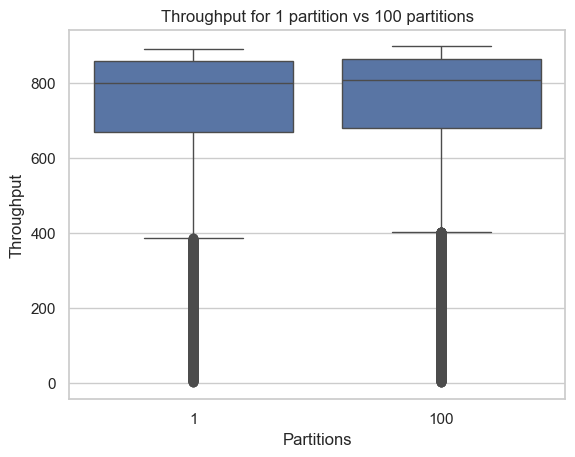

In [36]:
# visualization of the throuput for 1 partition vs 100 partitions
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# with throughput and standard deviation in the same plot vairables: throughput_list, calculate_std_dev(throughput_list)

print(throughput_list.__len__())
print(throughput_list_100.__len__())

data = pd.DataFrame(
    {
        "Throughput": throughput_list + throughput_list_100,
        "Partitions": ["1"] * 10000 + ["100"] * 10000,
    }
)

# make a boxplot
sns.set(style="whitegrid")
ax = sns.boxplot(x="Partitions", y="Throughput", data=data)
plt.title("Throughput for 1 partition vs 100 partitions")
plt.show()


## Experiment 5: Replication Factor Throughput Comparison (1 vs. 3)

### Objective
My goal was to measure and compare the message throughput of a Kafka-based system with different replication factors. Specifically, I wanted to see how the throughput changes when the replication factor is set to 1 compared to 3.

### Setup
I set up a Kafka environment with three brokers to allow for a replication factor up to 3. For the messaging part, I used a Python application leveraging the `confluent_kafka` library to produce messages. The messages were serialized using Protobuf to simulate real-world bus data, including GPS coordinates, bus capacity, and other metrics.

### Procedure
1. I ran my SmartBus application with Kafka's replication factor set to 1, sending a total of 10,000 messages per experiment iteration. I repeated this process 100 times to get a good statistical sample.
2. I then changed the replication factor of Kafka to 3 and repeated the experiment under the same conditions.
3. Throughout the experiments, I used `cProfile` to monitor performance and gather detailed metrics.

### Results
The throughput, in terms of messages per second (mps), was measured for both scenarios. With a replication factor of 1, the throughput was noticeably higher compared to when the replication factor was set to 3.

### Analysis
The decrease in throughput with a higher replication factor can be attributed to the additional overhead of ensuring data is replicated across more brokers. Each message must be written to three different brokers instead of one, which naturally requires more time and resources, thus affecting the overall throughput.

### Conclusion
The experiment confirmed that increasing the replication factor in Kafka impacts throughput negatively. While a higher replication factor enhances data durability and fault tolerance, it does come at the cost of performance. This trade-off between durability and throughput is crucial in designing systems where message delivery guarantees are critical. For my SmartBus application, deciding on the appropriate replication factor involves balancing the need for reliability against the system's performance requirements.

In [37]:
# docker-compose up
# docker remove all containers
remove_all_containers()
# sleep for 10 seconds
time.sleep(10)
subprocess.run(["docker-compose", "-f", "docker-compose.yml", "up", "-d"])
create_topics(replication_factor=1, partitions=10)
time.sleep(10)

result_1 = []
result_2 = []
result_3 = []

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [38]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = "localhost:19092,localhost:19093,localhost:19094"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(100):
        bench = smart_bus.send_bus_data()
        result_1.append(bench[0])

    print("Standard deviation: ", np.std(result_1))
    print("Average throughput: ", np.mean(result_1))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_1))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_1) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf_ReplicationFaktor1.prof")

Sent 10000 messages in 0.59 seconds.
Throughput: 16852.97 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22327.00 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22519.31 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22759.91 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22572.51 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22466.14 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22519.31 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22348.94 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22573.31 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22555.96 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 21987.76 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22299.54 messages per second. 

Sent 10000 messages in 0.45 

In [39]:
# docker-compose up
# docker remove all containers
remove_all_containers()
# sleep for 10 seconds
time.sleep(10)
subprocess.run(["docker-compose", "-f", "docker-compose.yml", "up", "-d"])
create_topics(replication_factor=2, partitions=10)
time.sleep(10)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [40]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = "localhost:19092,localhost:19093,localhost:19094"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(100):
        bench = smart_bus.send_bus_data()
        result_2.append(bench[0])

    print("Standard deviation: ", np.std(result_proto))
    print("Average throughput: ", np.mean(result_proto))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_proto))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_proto) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf_ReplicationFaktor2.prof")

Sent 10000 messages in 0.49 seconds.
Throughput: 20317.50 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21974.93 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 21004.18 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20717.38 messages per second. 

Sent 10000 messages in 0.47 seconds.
Throughput: 21381.17 messages per second. 

Sent 10000 messages in 0.50 seconds.
Throughput: 20183.34 messages per second. 

Sent 10000 messages in 0.50 seconds.
Throughput: 20073.82 messages per second. 

Sent 10000 messages in 0.50 seconds.
Throughput: 20003.97 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20791.59 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22007.42 messages per second. 

Sent 10000 messages in 0.49 seconds.
Throughput: 20235.36 messages per second. 

Sent 10000 messages in 0.51 seconds.
Throughput: 19543.34 messages per second. 

Sent 10000 messages in 0.48 

In [41]:
# docker-compose up
# docker remove all containers
remove_all_containers()
subprocess.run(["docker-compose", "-f", "docker-compose.yml", "up", "-d"])
create_topics(replication_factor=3, partitions=10)
time.sleep(10)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [42]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = "localhost:19092,localhost:19093,localhost:19094"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(100):
        bench = smart_bus.send_bus_data()
        result_3.append(bench[0])

    print("Standard deviation: ", np.std(result_proto))
    print("Average throughput: ", np.mean(result_proto))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_proto))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_proto) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf_ReplicationFaktor3.prof")

Sent 10000 messages in 0.48 seconds.
Throughput: 20720.85 messages per second. 

Sent 10000 messages in 0.64 seconds.
Throughput: 15540.49 messages per second. 

Sent 10000 messages in 0.47 seconds.
Throughput: 21357.67 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21914.24 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21574.15 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20909.76 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22125.46 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22255.55 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22306.96 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22092.23 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22082.35 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21910.22 messages per second. 

Sent 10000 messages in 0.46 

100
100
100
    replication_factor    throughput
0             result_1  16852.966715
1             result_1  22327.003549
2             result_1  22519.305657
3             result_1  22759.914415
4             result_1  22572.509064
..                 ...           ...
295           result_3  22628.698815
296           result_3  21766.610758
297           result_3  22540.678031
298           result_3  21130.431409
299           result_3  20191.181320

[300 rows x 2 columns]


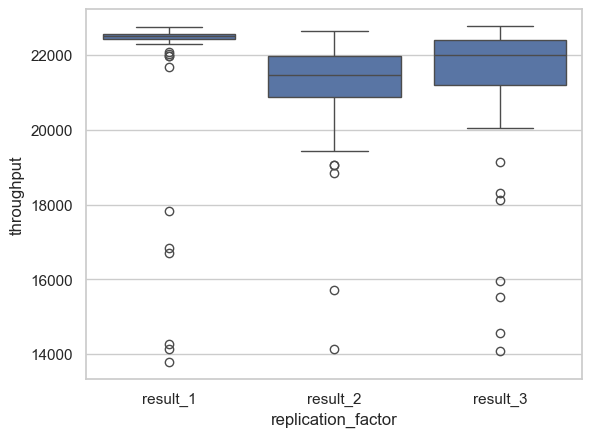

In [43]:
# visualization of the time taken without replication factor 3 vs replication factor 1
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# visualize the time taken without replication factor 3 vs replication factor 1 result_1 vs result_3
print(result_1.__len__())
print(result_2.__len__())
print(result_3.__len__())

data = {
    "result_1": result_1,
    "result_2": result_2,
    "result_3": result_3,
}

df = pd.DataFrame(data)
df = df.melt(var_name="replication_factor", value_name="throughput")
print(df)

# plot the data
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="replication_factor", y="throughput", data=df)
plt.show()

## Experiment 6: One vs 3 Brokers 

### Objective


### Setup


### Procedure


### Results

### Analysis

### Conclusion


In [44]:
# remove all containers
remove_all_containers()
# sleep for 10 seconds
time.sleep(10)
# compose up docker-compose_1Broker.yml
subprocess.run(["docker-compose", "-f", "docker-compose_1Broker.yml", "up", "-d"])
# create topics
create_topics(replication_factor=1, partitions=10)
time.sleep(10)
result_1Broker = []
result_5Broker = []

Failed to create topic bus_data: KafkaError{code=_TIMED_OUT,val=-185,str="Failed while waiting for controller: Local: Timed out"}
Failed to create topic restricted_area_alerts: KafkaError{code=_TIMED_OUT,val=-185,str="Failed while waiting for controller: Local: Timed out"}
Failed to create topic air_quality_data: KafkaError{code=_TIMED_OUT,val=-185,str="Failed while waiting for controller: Local: Timed out"}
Failed to create topic bus_service_station: KafkaError{code=_TIMED_OUT,val=-185,str="Failed while waiting for controller: Local: Timed out"}
Failed to create topic bus_locations: KafkaError{code=_TIMED_OUT,val=-185,str="Failed while waiting for controller: Local: Timed out"}


In [45]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = "localhost:19092"


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(10):
        bench = smart_bus.send_bus_data()
        result_1Broker.append(bench[0])

    print("Standard deviation: ", np.std(result_1Broker))
    print("Average throughput: ", np.mean(result_1Broker))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_1Broker))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_1Broker) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf_oneBroker.prof")

Sent 10000 messages in 1.05 seconds.
Throughput: 9520.34 messages per second. 

Sent 10000 messages in 0.51 seconds.
Throughput: 19718.44 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22191.32 messages per second. 

Sent 10000 messages in 0.52 seconds.
Throughput: 19199.40 messages per second. 

Sent 10000 messages in 0.50 seconds.
Throughput: 19845.08 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22568.55 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22369.08 messages per second. 

Sent 10000 messages in 0.44 seconds.
Throughput: 22552.18 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20753.09 messages per second. 

Sent 10000 messages in 0.45 seconds.
Throughput: 22414.25 messages per second. 

Standard deviation:  3746.4728351034
Average throughput:  20113.174255966424
Average time:  0.44614481925964355
Average messages:  10000.0
Total messages:  201131.74255966424
Total time:  0.4

In [46]:
# remove all containers
remove_all_containers()
# sleep 10
time.sleep(10)
# sleep for 10 seconds
# compose up docker-compose_1Broker.yml
subprocess.run(["docker-compose", "-f", "docker-compose_5Broker.yml", "up", "-d"])
# create topics
create_topics(replication_factor=1, partitions=10)
time.sleep(10)

Topic bus_data created
Topic restricted_area_alerts created
Topic air_quality_data created
Topic bus_service_station created
Topic bus_locations created


In [47]:
import math
import random
import time
import numpy as np
from confluent_kafka import Producer
import smartbus_pb2  # Ensure this matches the generated file name from your smartbus.proto
import cProfile
from typing import List

servers = (
    "localhost:19092,localhost:19093,localhost:19094,localhost:19095,localhost:19096"
)


class SmartBus:
    def __init__(self, servers):
        self.producer = Producer({"bootstrap.servers": servers})

    def delivery_report(self, err, msg):
        """Called once for each message produced to indicate delivery result.
        Triggered by poll() or flush()."""
        if err is not None:
            print(f"Message delivery failed: {err}")
        else:
            pass
            # print(f"Message delivered to {msg.topic()} [{msg.partition()}]")

    def generate_random_gps(self, lat, lon, radius):
        """Generate random GPS coordinates within a given radius around a central point"""
        radius_in_degrees = radius / 111300
        u = random.uniform(0, 1)
        v = random.uniform(0, 1)
        w = radius_in_degrees * math.sqrt(u)
        t = 2 * math.pi * v
        x = w * math.cos(t)
        y = w * math.sin(t)
        new_lat = x + lat
        new_lon = y / math.cos(lat * math.pi / 180) + lon  # Adjust for the latitude
        return new_lat, new_lon

    def send_bus_data(self, topic="bus_data", num_messages=10000):
        """Generate and send bus data messages"""
        start_time = time.time()  # Start timing
        bus_ids = [
            f"Bus{i}" for i in range(1, 21)
        ]  # Generate bus IDs Bus1 through Bus20
        bus_types = ["conventional", "electric"]
        # GPS coordinates for Basel, Switzerland
        basel_lat, basel_lon = 47.5596, 7.5886

        for _ in range(num_messages):  # Send 10 messages per second
            bus_message = smartbus_pb2.BusData()
            bus_message.bus_id = random.choice(bus_ids)
            bus_message.bus_type = random.choice(bus_types)
            lat, lon = self.generate_random_gps(basel_lat, basel_lon, 20000)
            bus_message.location.lat = lat
            bus_message.location.lon = lon
            bus_capacity = random.randint(30, 60)
            bus_message.bus_capacity = bus_capacity
            bus_message.people_in_bus = random.randint(0, bus_capacity)
            driving_time = random.uniform(0, 24)
            bus_message.driving_time = driving_time
            bus_message.driving_speed = random.uniform(0, 100)
            bus_message.engine_temperature = random.uniform(60, 120)
            bus_message.timestamp = time.time()
            # Fill in the black box data
            black_box = bus_message.black_box
            black_box.acceleration = random.uniform(0, 10)
            black_box.braking = random.uniform(0, 10)
            black_box.fuel_consumption = random.uniform(0, 10)
            black_box.tire_pressure = random.uniform(1, 3)
            for _ in range(random.randint(0, 5)):
                black_box.error_codes.append(random.randint(0, 100))
            if bus_message.bus_type == "conventional":
                bus_message.fuel_level = 100 - (100 / 24 * driving_time)
            else:
                bus_message.battery_level = 100 - random.uniform(0, 100) / (
                    driving_time * (100 / 24)
                )
            message_bytes = bus_message.SerializeToString()
            # In the SmartBus class, right before sending the message
            # print("Debug - Serialized message bytes:", message_bytes)
            # This won't be human-readable but confirms data is being serialized
            self.producer.produce(topic, message_bytes, callback=self.delivery_report)
            self.producer.poll(0)
        # time.sleep(0.2)  # Sleep for 1 second to maintain a 10 messages per second rate
        # calculate tps

        self.producer.flush()

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        messages_per_second = num_messages / elapsed_time
        print(f"Sent {num_messages} messages in {elapsed_time:.2f} seconds.")
        print(f"Throughput: {messages_per_second:.2f} messages per second. \n")
        return messages_per_second, elapsed_time, num_messages


def main():
    smart_bus = SmartBus(servers)
    for i in range(10):
        bench = smart_bus.send_bus_data()
        result_5Broker.append(bench[0])

    print("Standard deviation: ", np.std(result_5Broker))
    print("Average throughput: ", np.mean(result_5Broker))
    print("Average time: ", np.mean(bench[1]))
    print("Average messages: ", np.mean(bench[2]))
    print("Total messages: ", np.sum(result_5Broker))
    print("Total time: ", np.sum(bench[1]))
    print("Total throughput: ", np.sum(result_5Broker) / np.sum(bench[1]))


if __name__ == "__main__":
    cProfile.run("main()", "smartbus_profile_protobuf_threeBroker.prof")

Sent 10000 messages in 0.48 seconds.
Throughput: 20702.23 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21565.01 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 21046.31 messages per second. 

Sent 10000 messages in 0.47 seconds.
Throughput: 21126.39 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21616.78 messages per second. 

Sent 10000 messages in 0.47 seconds.
Throughput: 21359.37 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20644.24 messages per second. 

Sent 10000 messages in 0.46 seconds.
Throughput: 21610.48 messages per second. 

Sent 10000 messages in 0.49 seconds.
Throughput: 20562.06 messages per second. 

Sent 10000 messages in 0.48 seconds.
Throughput: 20899.36 messages per second. 

Standard deviation:  388.4033247443402
Average throughput:  21113.2222230525
Average time:  0.4784834384918213
Average messages:  10000.0
Total messages:  211132.22223052502
Total time:  0.4

10
10
            broker    throughput
0   result_1Broker   9520.344687
1   result_1Broker  19718.442553
2   result_1Broker  22191.321462
3   result_1Broker  19199.396503
4   result_1Broker  19845.083304
5   result_1Broker  22568.549557
6   result_1Broker  22369.084475
7   result_1Broker  22552.179725
8   result_1Broker  20753.093689
9   result_1Broker  22414.246604
10  result_5Broker  20702.225451
11  result_5Broker  21565.010658
12  result_5Broker  21046.308056
13  result_5Broker  21126.386980
14  result_5Broker  21616.780910
15  result_5Broker  21359.374196
16  result_5Broker  20644.236595
17  result_5Broker  21610.476973
18  result_5Broker  20562.057469
19  result_5Broker  20899.364943


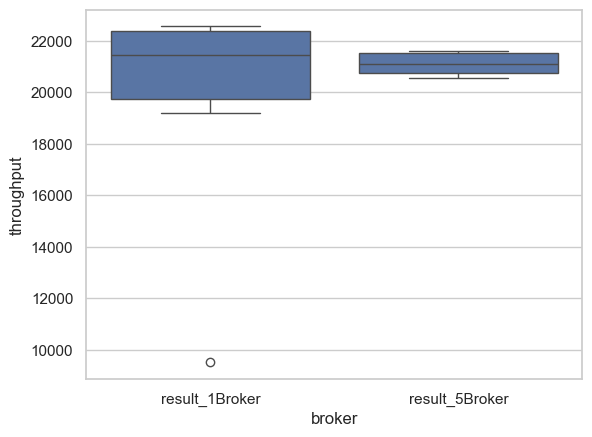

In [48]:
# visualization of the time taken without replication factor 1Broker vs 5Broker
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# visualize the time taken without replication factor 1Broker vs 5Broker result_1Broker vs result_5Broker
print(result_1Broker.__len__())
print(result_5Broker.__len__())

data = {
    "result_1Broker": result_1Broker,
    "result_5Broker": result_5Broker,
}

df = pd.DataFrame(data)
df = df.melt(var_name="broker", value_name="throughput")
print(df)

# plot the data
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="broker", y="throughput", data=df)
plt.show()

In [49]:
import os
import pstats
import io

# Get a list of all .prof files in the current directory
prof_files = [f for f in os.listdir() if f.endswith('.prof')]

# For each .prof file...
for prof_file in prof_files:
    # Read the file
    s = pstats.Stats(prof_file)
    
    # Redirect output to string stream
    stream = io.StringIO()
    s.stream = stream
    
    # Print the statistics
    s.sort_stats('cumulative').print_stats()
    
    # Get the stats string
    stats_str = stream.getvalue()
    
    # Print the stats string
    print(f'Stats for {prof_file}:\n{stats_str}\n\n')

Stats for smartbus_profile.prof:
Sat Mar 16 17:16:49 2024    smartbus_profile.prof

         1192005 function calls (1191968 primitive calls) in 0.644 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.044    0.000    0.150    0.000 {method 'poll' of 'cimpl.Producer' objects}
        7    0.000    0.000    0.146    0.021 c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py:86(_run)
    55099    0.018    0.000    0.129    0.000 c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\random.py:332(randint)
    10004    0.005    0.000    0.127    0.000 c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\json\__init__.py:183(dumps)
    10004    0.012    0.000    0.122    0.000 c:\Users\super\AppData\Local\Programs\Python\Python312\Lib\json\encoder.py:183(encode)
        2    0.000    0.000    0.119    0.059 C:\Users\super\AppData\Roaming\Python\Python312\site-packages\ipykernel\io